# Group ICA: a tutorial

Author: Pierre Ablin

Group ICA extends the celebrated Independent Component Analysis to multiple datasets.

Single view ICA decomposes a dataset $X$ as $X = S \times A^{\top}$, where $S$ are the independent sources (meaning that the columns of $S$ are independent), and $A$ is the mixing matrix.

In group ICA, we have several views $Xs = [X_1, \dots, X_n]$. Each view is obtained as 

$$
Xi \simeq S \times Ai.T
$$

so the views share the same sources $S$, but have different mixing matrices $A_i$.
It is a powerful tool for group inference, as it allows to extract signals that are comon across views.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mvlearn.decomposition import GroupICA

In [3]:
def plot_sources(S):
    n_samples, n_sources = S.shape
    fig, axes = plt.subplots(n_sources, 1, figsize=(6, 4), sharex=True)
    for ax, sig in zip(axes, S.T):
        ax.plot(sig)

First, let's define some sources:

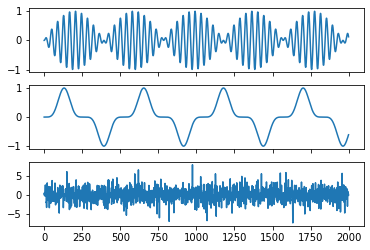

In [4]:
np.random.seed(0)
n_samples = 2000
time = np.linspace(0, 8, n_samples)

s1 = np.sin(2 * time) * np.sin(40 * time)
s2 = np.sin(3 * time) ** 5
s3 = np.random.laplace(size=s1.shape)

S = np.c_[s1, s2, s3]

plot_sources(S)

Next, generate some views, which are noisy observations of linear transforms of these sources:

In [5]:
n_views = 10
mixings = [np.random.randn(3, 3) for _ in range(n_views)]
Xs = [np.dot(S, A.T) + 0.3 * np.random.randn(n_samples, 3) for A in mixings]

We can visualize one dataset: it looks quite messy.

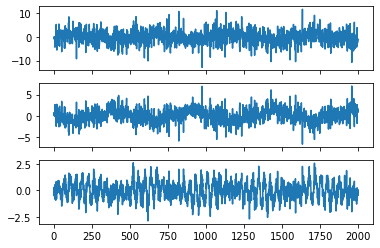

In [6]:
plot_sources(Xs[0])

Next, we can apply group ICA. The option `multiview_output=False` means that we want to recover the estimated sources when we do `.transform`.

In [7]:
groupica = GroupICA(multiview_output=False).fit(Xs)

Let's look at what the algorithm estimates:

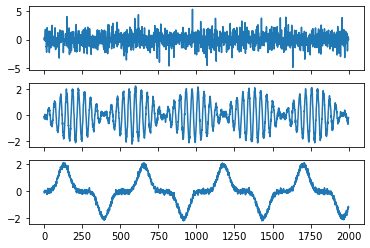

In [8]:
estimated_sources = groupica.transform(Xs)
plot_sources(estimated_sources)

Looks pretty good ! We can also wheck that it has correctly predicted each mixing matrix. The estimated mixing matrices are stored in the `.individual_mixing_` attribute.

In [9]:
estimated_mixings = groupica.individual_mixing_

If $\tilde{A}$ is the estimated mixing matrix and $A$ is the true mixing matrix, we can look at $\tilde{A}^{-1}A$. It should be close to a scale and permuation matrix: in this case, the sources are correctly estimated, up to scale and permutation.

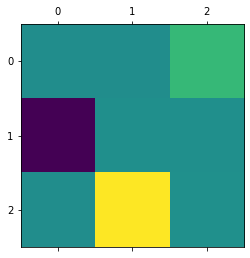

In [10]:
plt.matshow(np.dot(np.linalg.pinv(estimated_mixings[0]), mixings[0]))

A great advantage of groupICA is that it leverages the multiple views to reduce noise. For instance, if only had two views, we would have obtained:

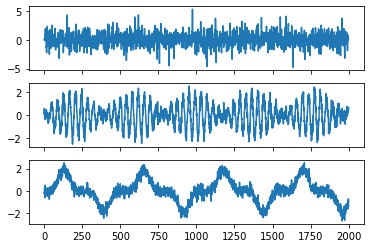

In [11]:
estimated_sources = groupica.fit_transform(Xs[:2])
plot_sources(estimated_sources)

Another important property of group ICA is that it can recover signals that are common to all datasets, and separate these signals from the rest. Imagine that we only have one common source across datasets:

In [12]:
common_source = S[:, 0]
mixings = np.random.randn(n_views, 3)
Xs = [a * common_source[:, None] + 0.3 * np.random.randn(n_samples, 3) for a in mixings]

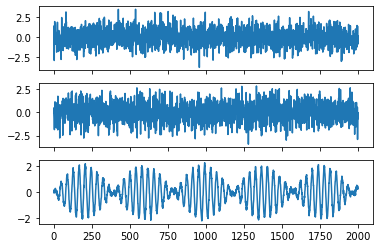

In [13]:
estimated_sources = groupica.fit_transform(Xs)
plot_sources(estimated_sources)

It recovers the common source on one channel, and the other estimated sources are noise.